# Web Scraping & Data Analysis


# Task 1 — Web Scraping 
This section is responsible for fetching 200 **titles** (TV shows or movies) from the TV Maze website, along with their corresponding properties as follows: **First air date**, **End date**, **Rating**, **Genres**, **Status**, **Network**, **Summary**, and save the results to `Jiahui.Hu+2252518.csv`.

## TVmaze Show Entry Collector
A self-contained Python scraper that gathers canonical TV show detail URLs from TVmaze seed pages (shows, popularity, rating, and calendar), discovers pagination, normalizes and deduplicates links, and exports a clean entry CSV for downstream processing.

### Dependencies & Base Config
Provide base constants, HTTP session, and polite throttling utilities.

In [1]:
import os, re, time, random
import requests
import pandas as pd 
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup

BASE = "https://www.tvmaze.com/"
REQUEST_DELAY = (0.8, 1.6)
TIMEOUT = 15
MAX_RETRY = 2

SESSION = requests.Session()
SESSION.headers.update({
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.9",
    "Connection": "keep-alive",
    "Referer": "https://www.tvmaze.com/",
    "Upgrade-Insecure-Requests": "1",
})
SESSION.cookies.set("cookieconsent_status", "dismiss")

def polite_sleep():
    time.sleep(random.uniform(*REQUEST_DELAY))

### URL & Request Helpers
Normalize URLs, perform resilient HTTP GET with retries, and parse HTML to Soup.

In [2]:
def sanitize_url(u: str, base=BASE) -> str:
    if not u:
        return None
    u = str(u).strip().strip("<>").strip().strip("<<<").strip(">>>").strip().strip('"').strip("'")
    if u.startswith("/"):
        u = urljoin(base, u)
    pr = urlparse(u)
    if not pr.scheme:
        u = "https://" + u.lstrip("/")
    return u

def safe_get(url, timeout=TIMEOUT, max_retry=MAX_RETRY):
    url = sanitize_url(url)
    last_exc = None
    for _ in range(max_retry + 1):
        try:
            resp = SESSION.get(url, timeout=timeout, allow_redirects=True)
            if resp.status_code == 200 and resp.text:
                return resp
        except Exception as e:
            last_exc = e
        polite_sleep()
    print(f"[safe_get] Failed: {url} — {last_exc}")
    return None

def get_soup(url):
    resp = safe_get(url)
    if not resp:
        return None
    return BeautifulSoup(resp.text, "html.parser")


### Listing Extraction Basics
Define matchers and extract normalized show URLs from listing pages.

In [3]:
ENTRY_OUTPUT = "entrylinks_Jiahui.Hu+2252518.csv"
SHOW_HREF_PAT = re.compile(r"^/shows/\d+([/-].*)?$", re.IGNORECASE)

def is_show_href(href: str) -> bool:
    return bool(href and SHOW_HREF_PAT.match(href.strip()))

def normalize_show_url(href: str) -> str:
    href = sanitize_url(href, base=BASE)
    return href.split("#")[0].split("?")[0]

def collect_from_listing(url: str) -> list:
    soup = get_soup(url)
    if not soup:
        return []
    links = []
    for a in soup.select("a"):
        href = a.get("href")
        if href and is_show_href(href):
            links.append(normalize_show_url(href))
    return links

### Pagination Discovery & Construction
Detect max pages and construct listing page URLs across ?page=n and /page/n patterns.

In [4]:
def discover_pagination(soup):
    if not soup:
        return 1
    max_page = 1
    for a in soup.select("a[href*='?page=']"):
        m = re.search(r"\d+", (a.get_text() or ""))
        if m:
            max_page = max(max_page, int(m.group()))
    for a in soup.select("a[href*='/page/']"):
        href = a.get("href") or ""
        m = re.search(r"/page/(\d+)", href)
        if m:
            max_page = max(max_page, int(m.group(1)))
    return max_page

def build_listing_pages(seed_urls: list, hard_cap_pages=50):
    pages, seen = [], set()
    for seed in seed_urls:
        seed = sanitize_url(seed, base=BASE)
        soup = get_soup(seed)
        if not soup:
            continue
        max_page = min(discover_pagination(soup), hard_cap_pages)
        use_query = bool(soup.select("a[href*='?page=']"))
        for p in range(1, max_page + 1):
            u = f"{seed.split('?')[0]}?page={p}" if use_query else seed + ("" if seed.endswith("/") else "/") + f"page/{p}"
            u = sanitize_url(u)
            if u not in seen:
                pages.append(u); seen.add(u)
        polite_sleep()
    return pages

### Main Collection Flow
Seed scrape → pagination backfill → cleanup and dedup to target size.

In [5]:
def collect_entry_show_urls(target_total=200):
    seed_list = [
        "https://www.tvmaze.com/shows",
        "https://www.tvmaze.com/shows?sort=popularity",
        "https://www.tvmaze.com/shows?sort=rating",
        "https://www.tvmaze.com/calendar",
        "https://www.tvmaze.com/seasons",
    ]
    all_links, seen = [], set()
    for seed in seed_list:
        for href in collect_from_listing(seed):
            if href not in seen:
                all_links.append(href); seen.add(href)
        polite_sleep()
        if len(all_links) >= target_total:
            break
    if len(all_links) < target_total:
        for pu in build_listing_pages(seed_list, hard_cap_pages=50):
            for href in collect_from_listing(pu):
                if href not in seen:
                    all_links.append(href); seen.add(href)
            polite_sleep()
            if len(all_links) >= int(target_total * 1.3):
                break
    clean, seen2 = [], set()
    for u in all_links:
        if "tvmaze.com/shows/" not in u:
            continue
        u2 = normalize_show_url(u)
        if u2 not in seen2:
            seen2.add(u2); clean.append(u2)
    return clean[:target_total]


### Execution & Export
Run the flow, persist results to CSV, and preview the head.

In [6]:
collected = collect_entry_show_urls(target_total=200)
print(f"Collected links: {len(collected)}")
entry_df_new = pd.DataFrame({"show_url": collected})
entry_df_new.to_csv(ENTRY_OUTPUT, index=False)
print(f"Saved entry CSV: {ENTRY_OUTPUT}")
entry_df_new.head(10)

[safe_get] Failed: https://www.tvmaze.com/seasons — None
[safe_get] Failed: https://www.tvmaze.com/seasons — None
[safe_get] Failed: https://www.tvmaze.com/calendar/page/1 — None
Collected links: 200
Saved entry CSV: entrylinks_Jiahui.Hu+2252518.csv


,show_url
0,https://www.tvmaze.com/shows/28276/the-witcher
1,https://www.tvmaze.com/shows/2993/stranger-things
2,https://www.tvmaze.com/shows/60/ncis
3,https://www.tvmaze.com/shows/112/south-park
4,https://www.tvmaze.com/shows/67/greys-anatomy
5,https://www.tvmaze.com/shows/15299/the-boys
6,https://www.tvmaze.com/shows/56/chicago-pd
7,https://www.tvmaze.com/shows/32158/fbi
8,https://www.tvmaze.com/shows/49964/invasion
9,https://www.tvmaze.com/shows/45039/slow-horses


### Entry CSV Load & Validation 
Load the collected entry CSV, validate schema, deduplicate, and cap to 200 rows.

In [7]:
if not os.path.exists(ENTRY_OUTPUT):
    raise FileNotFoundError(f"Entry CSV not found: {ENTRY_OUTPUT}")

entry_df = pd.read_csv(ENTRY_OUTPUT)
if "show_url" not in entry_df.columns:
    raise ValueError("ENTRY_OUTPUT CSV must contain a 'show_url' column.")

entry_df = (
    entry_df
    .drop_duplicates(subset=["show_url"])
    .reset_index(drop=True)
    .head(200)
    .copy()
)

print("Entry rows (limited to 200):", len(entry_df))
entry_df.head(5)


Entry rows (limited to 200): 200


,show_url
0,https://www.tvmaze.com/shows/28276/the-witcher
1,https://www.tvmaze.com/shows/2993/stranger-things
2,https://www.tvmaze.com/shows/60/ncis
3,https://www.tvmaze.com/shows/112/south-park
4,https://www.tvmaze.com/shows/67/greys-anatomy


## URL & Request Helpers
Provide polite rate-limiting, URL normalization, resilient HTTP GET with retries, and HTML-to-Soup parsing.

### Throttling & HTTP
Provide polite rate-limiting and resilient HTTP GET with retries/backoff.

In [8]:
def polite_sleep():
    time.sleep(random.uniform(*REQUEST_DELAY))

def sanitize_url(u: str, base=BASE) -> str:
    if not u:
        return None
    u = str(u).strip().strip("<>").strip().strip("<<<").strip(">>>").strip().strip('"').strip("'")
    if u.startswith("/"):
        u = urljoin(base, u)
    pr = urlparse(u)
    if not pr.scheme:
        u = "https://" + u.lstrip("/")
    return u

### URL & Parsing
Normalize and canonicalize URLs; fetch and parse HTML into BeautifulSoup.

In [9]:
def safe_get(url, timeout=TIMEOUT, max_retry=MAX_RETRY):
    url = sanitize_url(url)
    last_exc = None
    for _ in range(max_retry + 1):
        try:
            resp = SESSION.get(url, timeout=timeout, allow_redirects=True)
            if resp.status_code == 200 and resp.text:
                return resp
        except Exception as e:
            last_exc = e
        polite_sleep()
    print(f"[safe_get] Failed: {url} — {last_exc}")
    return None

def get_soup(url):
    resp = safe_get(url)
    if not resp:
        return None
    return BeautifulSoup(resp.text, "html.parser")

## TVmaze Show Metadata Harvester
End-to-end Python toolkit that discovers TV show entries on TVmaze, traverses listings with pagination, and scrapes structured metadata per show. It normalizes/validates URLs, performs polite and resilient HTTP fetching, parses HTML to extract core fields (title, summary, rating, genres, status, network), derives first/last air dates from episode lists with fallbacks, and exports curated show URLs plus parsed records for downstream analytics or indexing.

### Show Detail Field Extractors (Basics)
Extract core fields directly from a show detail page (title, summary, rating, genres, status, network).

In [10]:
def extract_title(soup):
    el = soup.select_one("h1.show-for-medium")
    if el:
        return el.get_text(strip=True)
    h1 = soup.find("h1")
    return h1.get_text(strip=True) if h1 else None

def extract_summary(soup):
    el = soup.select_one("#general-information article")
    return el.get_text(" ", strip=True) if el else None

def extract_rating(soup):
    el = soup.select_one('[itemprop="ratingValue"]')
    if el:
        return el.get_text(strip=True)

    agg = soup.select_one('[itemprop="aggregateRating"]')
    if agg:
        m = re.search(r"[\d\.]+", agg.get_text(" ", strip=True))
        if m:
            return m.group(0)

    for s in soup.select('script[type="application/ld+json"]'):
        try:
            data = json.loads(s.string) if s.string else None
            if isinstance(data, dict) and "aggregateRating" in data:
                val = data["aggregateRating"].get("ratingValue")
                if val:
                    return str(val)
        except Exception:
            pass
    return None

def extract_genres(soup):
    def dedup_keep_order(items):
        seen, out = set(), []
        for x in items:
            x = (x or "").strip()
            if x and x not in seen:
                seen.add(x); out.append(x)
        return out

    def normalize_to_list(obj):
        if not obj:
            return []
        if isinstance(obj, list):
            return dedup_keep_order(map(str, obj))
        txt = str(obj).strip()
        if not txt:
            return []
        q = re.findall(r"[\"']([^\"']+)[\"']", txt)
        if q:
            return dedup_keep_order(q)
        parts = re.split(r"\s*\|\s*|\s*,\s*|\s*/\s*|\s*;\s*|\s*[•·]\s*|\s{2,}", txt)
        parts = [p for p in parts if p.strip()]
        if len(parts) <= 1:
            parts = re.split(r"\s+", txt)
        parts = [p.strip() for p in parts if p.strip().lower() != "genres"]
        return dedup_keep_order(parts)

    def to_pylist_str(lst):
        lst = normalize_to_list(lst)
        return "[]" if not lst else "[" + ", ".join(f"'{x}'" for x in lst) + "]"

    panel = soup.select_one("#general-info-panel")
    if panel:
        lab = next((st for st in panel.find_all("strong")
                    if (st.get_text(strip=True) or "").lower().startswith("genres")), None)
        if lab:
            row = lab.parent or lab.find_parent()
            if row:
                items = [a.get_text(strip=True) for a in row.select("a") if a.get_text(strip=True)]
                if items:
                    return to_pylist_str(items)
                raw = row.get_text(" ", strip=True) or ""
                raw = raw.split(":", 1)[-1].strip() if ":" in raw else raw
                return to_pylist_str(raw)

    fallback = [a.get_text(strip=True)
                for a in soup.select(".genres a, a[href*='/shows?genre=']")
                if a.get_text(strip=True)]
    return to_pylist_str(fallback)

def extract_status(soup):
    panel = soup.select_one("#general-info-panel")
    if not panel:
        return None
    tgt = None
    for st in panel.find_all("strong"):
        if "status" in st.get_text(strip=True).lower():
            tgt = st
            break
    if not tgt:
        return None
    row_text = " ".join(tgt.parent.get_text(" ", strip=True).split())
    m = re.search(r"\b(Running|Ended|To Be Determined|In Development)\b", row_text, re.I)
    status = m.group(1).title() if m else None
    ret = None
    link = tgt.parent.select_one("a")
    if link:
        ret = (link.get_text() or "").strip()
    if not ret:
        m2 = re.search(r"\b(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{4}\b", row_text, re.I)
        if m2:
            ret = m2.group(0).title()
    return f"{status}; returning {ret}" if status and ret else status

def extract_network(soup):
    panel = soup.select_one("#general-info-panel")
    if not panel:
        return None
    tgt = None
    for st in panel.find_all("strong"):
        t = st.get_text(strip=True).lower()
        if t.startswith("network") or t.startswith("web channel"):
            tgt = st
            break
    if not tgt:
        return None
    for sib in tgt.next_siblings:
        if hasattr(sib, "get_text"):
            name = sib.get_text(strip=True)
            if name:
                return name
    return None


### Episode URLs, Date Parsing, and Airdate Aggregation
Build episodes URL from a show URL, parse various date formats, and collect episode air dates from the episodes page.

In [11]:
def episodes_url_from_show_url(show_url: str):
    show_url = sanitize_url(show_url)
    if not show_url.endswith('/'):
        show_url += '/'
    return urljoin(show_url, "episodes")

def parse_date_any(text: str):
    if not text:
        return None
    t = " ".join(str(text).split())
    m = re.search(r"(\d{4})[-/](\d{1,2})[-/](\d{1,2})", t)
    if m:
        y, mn, d = map(int, m.groups())
        return f"{y:04d}-{mn:02d}-{d:02d}"
    m = re.search(r"(\d{1,2})/(\d{1,2})/(\d{4})", t)
    if m:
        mn, d, y = map(int, m.groups())
        return f"{y:04d}-{mn:02d}-{d:02d}"
    m = re.search(r"([A-Za-z]+)\s+(\d{1,2}),\s*(\d{4})", t)
    if m:
        mon_name, d, y = m.groups()
        d, y = int(d), int(y)
        months = {
            'jan':1,'january':1,'feb':2,'february':2,'mar':3,'march':3,
            'apr':4,'april':4,'may':5,'jun':6,'june':6,'jul':7,'july':7,
            'aug':8,'august':8,'sep':9,'sept':9,'september':9,'oct':10,'october':10,
            'nov':11,'november':11,'dec':12,'december':12
        }
        mn = months.get(mon_name.strip().lower())
        if mn:
            return f"{y:04d}-{mn:02d}-{d:02d}"
    return None

def collect_episode_dates(ep_soup):
    if not ep_soup:
        return []
    cells = ep_soup.select("article.episode-row div.small-3.medium-2.cell")
    if not cells:
        cells = ep_soup.select(".episode-row .small-3.medium-2.cell, .episode-row .airdate, .episode-row time")
    vals = []
    for el in cells:
        txt = el.get_text(strip=True)
        dt = parse_date_any(txt)
        if dt:
            vals.append(dt)
    return sorted(set(vals))


### Airdate Derivation and Fallbacks
Derive first air date and end date primarily from the episodes list; fall back to detail page panels when necessary.


In [12]:

def extract_first_and_end_dates(show_url: str, detail_soup):
    ep_url = episodes_url_from_show_url(show_url)
    ep_soup = get_soup(ep_url)

    dates = collect_episode_dates(ep_soup)
    first_air = dates[0] if dates else None
    end_date  = dates[-1] if dates else None

    if not first_air and detail_soup is not None:
        prem = None
        panel = detail_soup.select_one("#general-info-panel")
        if panel:
            for st in panel.find_all("strong"):
                if st.get_text(strip=True).lower().startswith("premiered"):
                    txt = ""
                    for sib in st.next_siblings:
                        if getattr(sib, "string", None):
                            txt += " " + sib.string.strip()
                        if hasattr(sib, "get_text"):
                            txt += " " + sib.get_text(strip=True)
                    prem = txt.strip()
                    break
        first_air = parse_date_any(prem) if prem else first_air

    if not end_date and detail_soup is not None:
        ended = None
        panel = detail_soup.select_one("#general-info-panel")
        if panel:
            for st in panel.find_all("strong"):
                if st.get_text(strip=True).lower().startswith("ended"):
                    txt = ""
                    for sib in st.next_siblings:
                        if getattr(sib, "string", None):
                            txt += " " + sib.string.strip()
                        if hasattr(sib, "get_text"):
                            txt += " " + sib.get_text(strip=True)
                    ended = txt.strip()
                    break
        end_date = parse_date_any(ended) if ended else end_date

    return first_air, end_date


### Show Page Parser and Sampling Runner
Orchestrate field extraction for a single show URL into a structured record, and demo-run on a small sample set.


In [13]:
def parse_show_page(show_url):
    show_url = sanitize_url(show_url)
    soup = get_soup(show_url)
    if not soup:
        return None

    title   = extract_title(soup)
    summary = extract_summary(soup)
    rating  = extract_rating(soup)
    genres  = extract_genres(soup)
    status  = extract_status(soup)
    network = extract_network(soup)
    first_air, end_date = extract_first_and_end_dates(show_url, soup)

    return {
        "Title": title,
        "First air date": first_air,
        "End date": end_date,
        "Rating": rating,
        "Genres": genres,
        "Status": status,
        "Network": network,
        "Summary": summary,
    }

sample_urls = entry_df['show_url'].head(5).tolist()
pd.DataFrame([parse_show_page(u) for u in sample_urls])

,Title,First air date,End date,Rating,Genres,Status,Network,Summary
0,The Witcher,2019-12-20,2025-10-30,8,"['Drama', 'Action', 'Fantasy']",Running; returning October 2025,Netflix,"Based on the best-selling fantasy series, The ..."
1,Stranger Things,2016-07-15,2025-12-31,8.5,"['Drama', 'Horror', 'Science-Fiction']",Running; returning November 2025,Netflix,"When a young boy vanishes, a small town uncove..."
2,NCIS,2006-09-19,2025-12-16,7.9,"['Drama', 'Action', 'Crime']",Running,CBS,NCIS (Naval Criminal Investigative Service) is...
3,South Park,1992-12-08,2025-12-10,8.3,['Comedy'],Running,Comedy Central,South Park is an adult comedy animation show c...
4,Grey's Anatomy,2005-09-25,2025-11-13,7.7,"['Drama', 'Romance', 'Medical']",Running,ABC,The doctors of Grey Sloan Memorial Hospital de...


## TV Show Batch Harvesting, Normalization, and Export Pipeline
Execute an end-to-end batch flow that parses show pages into structured records, minimally normalizes the dataset for analysis, and exports a schema-validated CSV with basic sanity checks.

### Batch Harvesting Runner
Iterate through all show URLs, parse each page into a record, throttle between requests, and accumulate results for downstream processing.


In [14]:
required_cols = ["Title","First air date","End date","Rating","Genres","Status","Network","Summary"]

records = []
urls = entry_df['show_url'].tolist()
for i, u in enumerate(urls, start=1):
    rec = parse_show_page(u)
    if rec:
        records.append(rec)
    print(f"[{i}/{len(urls)}] parsed: {rec is not None}")
    polite_sleep()

df = pd.DataFrame(records)


[1/200] parsed: True
[2/200] parsed: True
[3/200] parsed: True
[4/200] parsed: True
[5/200] parsed: True
[6/200] parsed: True
[7/200] parsed: True
[8/200] parsed: True
[9/200] parsed: True
[10/200] parsed: True
[11/200] parsed: True
[12/200] parsed: True
[13/200] parsed: True
[14/200] parsed: True
[15/200] parsed: True
[16/200] parsed: True
[17/200] parsed: True
[18/200] parsed: True
[19/200] parsed: True
[20/200] parsed: True
[21/200] parsed: True
[22/200] parsed: True
[23/200] parsed: True
[24/200] parsed: True
[25/200] parsed: True
[26/200] parsed: True
[27/200] parsed: True
[28/200] parsed: True
[29/200] parsed: True
[30/200] parsed: True
[31/200] parsed: True
[32/200] parsed: True
[33/200] parsed: True
[34/200] parsed: True
[35/200] parsed: True
[36/200] parsed: True
[37/200] parsed: True
[38/200] parsed: True
[39/200] parsed: True
[40/200] parsed: True
[41/200] parsed: True
[42/200] parsed: True
[43/200] parsed: True
[44/200] parsed: True
[45/200] parsed: True
[46/200] parsed: Tr

### Minimal Post-processing and Quick Preview
Ensure required columns exist, coerce Rating to numeric for analysis, and present a brief preview for sanity checking.

In [15]:
for c in required_cols:
    if c not in df.columns:
        df[c] = None

df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")

display(df.head(5))

,Title,First air date,End date,Rating,Genres,Status,Network,Summary
0,The Witcher,2019-12-20,2025-10-30,8.0,"['Drama', 'Action', 'Fantasy']",Running; returning October 2025,Netflix,"Based on the best-selling fantasy series, The ..."
1,Stranger Things,2016-07-15,2025-12-31,8.5,"['Drama', 'Horror', 'Science-Fiction']",Running; returning November 2025,Netflix,"When a young boy vanishes, a small town uncove..."
2,NCIS,2006-09-19,2025-12-16,7.9,"['Drama', 'Action', 'Crime']",Running,CBS,NCIS (Naval Criminal Investigative Service) is...
3,South Park,1992-12-08,2025-12-10,8.3,['Comedy'],Running,Comedy Central,South Park is an adult comedy animation show c...
4,Grey's Anatomy,2005-09-25,2025-11-13,7.7,"['Drama', 'Romance', 'Medical']",Running,ABC,The doctors of Grey Sloan Memorial Hospital de...


### Export and Sanity Checks
Reorder columns to the rubric, export to CSV, report output stats, and enforce basic assertions on row count and schema to catch pipeline regressions.


In [16]:
OUTPUT_CSV = "Jiahui.Hu+2252518.csv"

df = df[required_cols]
df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved CSV: {OUTPUT_CSV} — rows: {len(df)}")

assert len(df) == 200, "Row count must be exactly 200"
assert list(df.columns) == required_cols, "Columns must match the rubric exactly"
print("Basic checks passed.")

Saved CSV: Jiahui.Hu+2252518.csv — rows: 200
Basic checks passed.


# Task 2 — Data Analysis
This section is responsible for conducting exploratory analysis and visualization on the 200 scraped titles, proposing hypotheses around a self-defined theme, validating them with data, and ultimately presenting a concise, data-driven story supported by multiple informative figures.

In [1]:
pip install scikit-posthocs

Note: you may need to restart the kernel to use updated packages.


## Introduction

The streaming boom and global distribution have unleashed an unprecedented wave of high-quality series, but excellence does not appear randomly along the timeline. In collective memory, certain years feel like hotbeds of masterpieces, while others are remembered as valleys of mixed reception. At the same time, a show’s renewal status is often treated as a quality signal: running series suggest momentum and platform support, whereas ended ones are more likely to be canonized as “classics” with time.

This study centers on the theme “Era and Quality,” anchored by three intertwined questions, and explores the corresponding hypotheses around them.

- Q1: Does the premiere year exhibit a recognizable pattern in audience ratings, and can we pinpoint genuine “golden windows” of television?
- H1: Yes. There is a recognizable high‑rating cluster by premiere year; the golden window centers around 2010.
  
- Q2: Do Running and Ended shows occupy different landscapes of acclaim—are top-rated titles more concentrated among completed series, or do long-running productions sustain high quality over time?
- H2: Yes. Top‑rated titles are more concentrated among long‑running (Running) series rather than Ended series.
  
- Q3: From the perspective of “time as ally,” does longevity genuinely correlate with better reception, or is that impression largely a by-product of survivor bias
- H3: Related. Series longevity (run length/years) is associated with better reception, though survivor bias and selection effects may play a role.
  
By framing the inquiry around these questions, we aim to sketch the macro contours of quality fluctuations across decades, clarify how “classics” are shaped by their eras, and probe the tension between public sentiment and industry dynamics. Ultimately, we will identify plausible golden periods, characterize the relationship between renewal status and acclaim, and reflect on how sample composition and memory biases color what we recognize as quality.

## Environment and data foundations

### Import and global Settings
Prior to addressing the research questions, the analysis must be reproducible and visuals consistent. The environment is configured by importing pandas/numpy for data handling, seaborn/matplotlib for visualization, and scipy/statsmodels for statistical procedures, together with a unified plotting theme and Unicode-safe fonts to ensure correct label rendering. This setup prevents discrepancies in figure styles or text encoding and establishes a stable base for subsequent steps.

In [2]:
# 1) Imports and settings
import warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from itertools import combinations
import ast

warnings.simplefilter("default")
sns.set(style="whitegrid")
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "SimHei", "Noto Sans CJK SC", "Microsoft YaHei"]
plt.rcParams["axes.unicode_minus"] = False

### Read the original data
With the toolchain in place, the scraped CSV is loaded into a DataFrame to assess the available information. An initial inspection confirms the presence of key fields for the “Era and Quality” inquiry—Title, First/End dates, Rating, Genres, Status, Network, and Summary. At this stage the dataset remains in a raw, web-scraped state: dates are stored as strings, numeric ratings may mix types, and categorical fields (Genres, Status, Network) exhibit heterogeneous formatting. These observations motivate the next phase—systematic cleaning and feature construction—so that time, status, and genre information become analytically reliable for the downstream analyses.

In [3]:
# 2) Read CSV
path = "Jiahui.Hu+2252518.csv"
df_raw = pd.read_csv(path)
display(df_raw.head(3))

,Title,First air date,End date,Rating,Genres,Status,Network,Summary
0,The Witcher,2019-12-20,2025-10-30,8.0,"['Drama', 'Action', 'Fantasy']",Running; returning October 2025,Netflix,"Based on the best-selling fantasy series, The ..."
1,Stranger Things,2016-07-15,2025-12-31,8.5,"['Drama', 'Horror', 'Science-Fiction']",Running; returning November 2025,Netflix,"When a young boy vanishes, a small town uncove..."
2,NCIS,2006-09-19,2025-12-16,7.9,"['Drama', 'Action', 'Crime']",Running,CBS,NCIS (Naval Criminal Investigative Service) is...


## Feature engineering and sample construction
After clarifying the research questions and setting up the environment, the next core task is to convert the scraped data into a measurable and comparable feature matrix. In their raw form, records often suffer from inconsistent column names, mixed data types, and heterogeneous category labels; using them directly for an “era and quality” analysis would risk mistaking parsing noise for true period differences.

### Rename and basic types
The dataset currently has inconsistent headers, dates stored as strings, and ratings with mixed types, which makes references and calculations unstable. To address this, columns are standardized to concise names; first/last air dates are parsed as datetimes; ratings are coerced to numeric with safe nulling of bad entries; and the premiere year (year_first) is extracted as the temporal anchor.

In [4]:
# 3) Rename and basic types
rename_map = {
    "Title": "Title",
    "First air date": "first_air_date",
    "End date": "end_date",
    "Rating": "Rating_w",
    "Genres": "Genres",
    "Status": "Status",
    "Network": "Network",
    "Summary": "Summary",
}
df = df_raw.rename(columns=rename_map)

df["first_air_date"] = pd.to_datetime(df["first_air_date"], errors="coerce")
df["end_date"] = pd.to_datetime(df["end_date"], errors="coerce")
df["Rating_w"] = pd.to_numeric(df["Rating_w"], errors="coerce")
df["year_first"] = df["first_air_date"].dt.year
display(df[["Title","first_air_date","end_date","Rating_w","Status","Network"]].head(5))

,Title,first_air_date,end_date,Rating_w,Status,Network
0,The Witcher,2019-12-20,2025-10-30,8.0,Running; returning October 2025,Netflix
1,Stranger Things,2016-07-15,2025-12-31,8.5,Running; returning November 2025,Netflix
2,NCIS,2006-09-19,2025-12-16,7.9,Running,CBS
3,Grey's Anatomy,2005-09-25,2025-11-13,7.7,Running,ABC
4,South Park,1992-12-08,2025-12-10,8.3,Running,Comedy Central


### Duration and status normalization
Ongoing shows lack true end dates, and status strings appear in many variants, which hinders comparable duration and lifecycle grouping. The approach is: when an end date exists, compute duration directly; otherwise, use “today” as a conservative proxy for running titles and null any illogical spans. Status labels are collapsed into a small, consistent set (Running, Ended, In Development, To Be Determined), and platform names are cleaned with missing values grouped into Other.

In [5]:
# 4) Duration and status normalization
today = pd.Timestamp.today().normalize()
running_like = df["Status"].fillna("").str.contains("Running|Returning|To Be Determined|TBD|To be determined", case=False, na=False)
end_proxy = np.where(df["end_date"].notna(), df["end_date"], np.where(running_like, today, np.nan))
end_proxy = pd.to_datetime(end_proxy, errors="coerce")
df["duration_years"] = (end_proxy - df["first_air_date"]).dt.days.div(365.25)
df.loc[df["duration_years"] < 0, "duration_years"] = np.nan

def normalize_status(s: str) -> str:
    if not isinstance(s, str): return np.nan
    s_low = s.lower()
    if "ended" in s_low: return "Ended"
    if "in development" in s_low: return "In Development"
    if "to be determined" in s_low or "tbd" in s_low: return "To Be Determined"
    if "running" in s_low or "return" in s_low: return "Running"
    return s.strip()

df["Status_bin"] = df["Status"].apply(normalize_status)
df["Network_top"] = df["Network"].astype(str).replace({"nan": np.nan}).fillna("Other").str.strip()
display(df[["Title","year_first","duration_years","Status_bin","Network_top"]].head(5))

,Title,year_first,duration_years,Status_bin,Network_top
0,The Witcher,2019,5.861739,Running,Netflix
1,Stranger Things,2016,9.462012,Running,Netflix
2,NCIS,2006,19.241615,Running,CBS
3,Grey's Anatomy,2005,20.134155,Running,ABC
4,South Park,1992,33.004791,Running,Comedy Central


### Parse genres and build dummies
Genre fields arrive as heterogeneous strings or list-like text, making multi-genre analysis unreliable. A parser standardizes them into lists and expands them into binary indicators (genre_*). In addition, a decade variable is derived from year_first to support era-level comparisons and smooth single-year noise.

In [6]:
# 5) Parse genres and build dummies
def parse_genres(g):
    if isinstance(g, list): return g
    if isinstance(g, str):
        g = g.strip()
        if g == "" or g.lower()=="nan": return []
        try:
            out = ast.literal_eval(g)
            if isinstance(out, list): return [str(x).strip() for x in out]
        except Exception:
            g2 = g.strip("[]")
            return [x.strip(" '\"") for x in g2.split(",") if x.strip(" '\"")]
    return []

df["Genres_list"] = df["Genres"].apply(parse_genres)
all_genres = sorted({g for lst in df["Genres_list"] for g in lst})
for g in all_genres:
    safe = g.replace(" ", "_").replace("-", "_").replace("&", "and").replace(".", "").replace("/", "_")
    df[f"genre_{safe}"] = df["Genres_list"].apply(lambda lst: int(g in lst))

df["decade"] = (df["year_first"] // 10 * 10).astype("Int64").astype(str) + "s"
genre_cols_all = [c for c in df.columns if c.startswith("genre_")]
display(df[["Title","Genres","Genres_list"] + genre_cols_all[:5]].head(3))

,Title,Genres,Genres_list,genre_Action,genre_Adult,genre_Adventure,genre_Anime,genre_Comedy
0,The Witcher,"['Drama', 'Action', 'Fantasy']","[Drama, Action, Fantasy]",1,0,0,0,0
1,Stranger Things,"['Drama', 'Horror', 'Science-Fiction']","[Drama, Horror, Science-Fiction]",0,0,0,0,0
2,NCIS,"['Drama', 'Action', 'Crime']","[Drama, Action, Crime]",1,0,0,0,0


### Build analytical dataset and control dimensions
Without scope control, long-tail platforms and rare genres lead to unstable groups and noisy comparisons. The analytical view retains the narrative fields (Title, Summary), core targets and controls (Rating, year_first, duration_years, Status, Status_bin, Network_top, decade), and all genre indicators; rows missing a rating or premiere year are removed. For stable comparisons, only the five most represented platforms are kept (others grouped as Other), and genres are retained only if they appear at least 15 times.

In [7]:
# 6) Build df_an and control dimensions
base_cols = ["Title","Summary","Rating_w","year_first","duration_years","Status","Status_bin","Network_top","decade"]
df_an = df[base_cols + genre_cols_all].copy()
df_an = df_an.dropna(subset=["Rating_w","year_first"]).reset_index(drop=True)

top5 = df_an["Network_top"].value_counts().head(5).index.tolist()
df_an["Network_top"] = np.where(df_an["Network_top"].isin(top5), df_an["Network_top"], "Other")

genre_freq = df_an[[c for c in df_an.columns if c.startswith("genre_")]].sum().sort_values(ascending=False)
keep_genres = genre_freq[genre_freq >= 15].index.tolist()
genre_cols = keep_genres

print("Platforms kept (Top5+Other):", sorted(pd.Index(top5).tolist() + ["Other"]))
print("Genres kept (>=15):", len(genre_cols))

Platforms kept (Top5+Other): ['Apple TV', 'CBS', 'Netflix', 'Other', 'Paramount+', 'Prime Video']
Genres kept (>=15): 8


With these steps, the raw data have been systematically transformed into a structured feature set. Key information on time, lifecycle, genre, and platform is now ready for aggregation, visualization, and modeling. Based on this sample, the next phase proceeds to exploratory analysis and statistical testing to evaluate whether a genuine “golden era” exists, how ratings differ between running and ended shows, and how genres and platforms interact across eras.

## Exploratory analysis on the time dimension (why decade fixed effects)
After completing feature engineering and assembling the analytical dataset, the next step is to examine temporal patterns to assess whether time itself confounds ratings. Reviewing coverage and trends by year helps determine whether decade fixed effects are needed in subsequent models.

### Yearly aggregation
To obtain a reproducible, comparable snapshot for diagnosing temporal confounding before deciding on decade fixed effects, we group by the premiere year (year_first), compute the yearly show count (n) and the mean and median ratings (rating_mean, rating_median), and compile them into a tidy yearly table that serves as the single source for all downstream visuals and diagnostics.

In [8]:
# 7) Yearly aggregation
yearly_stats = (df_an
                .groupby("year_first")
                .agg(n=("Title","count"),
                     rating_mean=("Rating_w","mean"),
                     rating_median=("Rating_w","median"))
                .reset_index())
display(yearly_stats.head(5))

,year_first,n,rating_mean,rating_median
0,1977,1,5.9,5.9
1,1992,1,8.3,8.3
2,1993,1,8.6,8.6
3,1994,2,7.9,7.9
4,1997,1,8.8,8.8


Data analysis：
- In the early years (e.g., 1977, 1992, 1993, 1994, 1997), the yearly sample size is n=1, and the yearly mean equals the median (e.g., 5.9, 8.3, 8.6, 7.9, 8.8).
  
Interpretation：
- Early-year statistics are entirely determined by single titles and thus have very weak representativeness; the highs and lows in those years reflect idiosyncratic cases rather than population-level shifts.

### Test whether coverage is skewed toward recent years
Because uneven coverage—often concentrated in recent years—can bias summaries and exaggerate trends, we plot the annual count n as a line or bar chart to detect recency concentration, keeping axis labels and styling consistent with the analytical environment for seamless reuse across notebooks and reports.

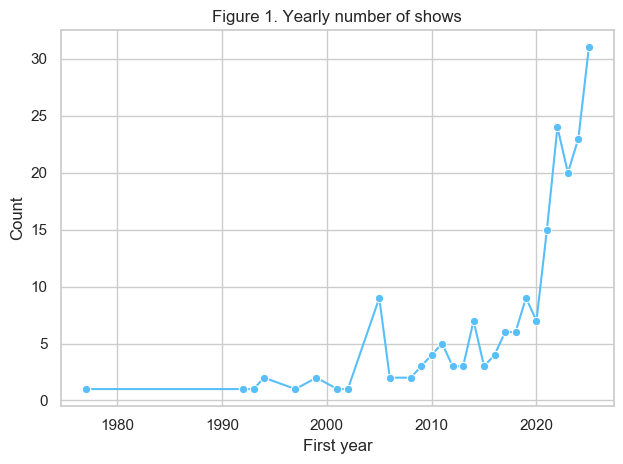

In [9]:
# 8) Figure 1: Yearly number of shows
plt.figure()
sns.lineplot(data=yearly_stats, x="year_first", y="n", marker="o", color="#58BFF9")
plt.title("Figure 1. Yearly number of shows")
plt.xlabel("First year"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

Data analysis：
- From roughly 1980–2010, counts stay low (n≈0–3), with only a brief spike around 2003 (≈9).
After 2015, counts rise clearly; around 2020 they accelerate to double digits and fluctuate roughly 15→25→20→32, setting new series highs.

Interpretation：
- The time distribution is strongly right-skewed, with a heavy concentration in recent years. Overall comparisons will be dominated by recent observations, while early years have a diluted influence on aggregate conclusions.

### Identify long-run trends and nonlinearity in ratings
Since ratings may shift nonlinearly over time and slow, era‑level movements inform the need for fixed effects, we plot yearly rating_mean and rating_median together and overlay a LOWESS smoother on the mean (with a moderate span); using both mean and median provides a robust view that resists skew and outliers in thin-sample years.

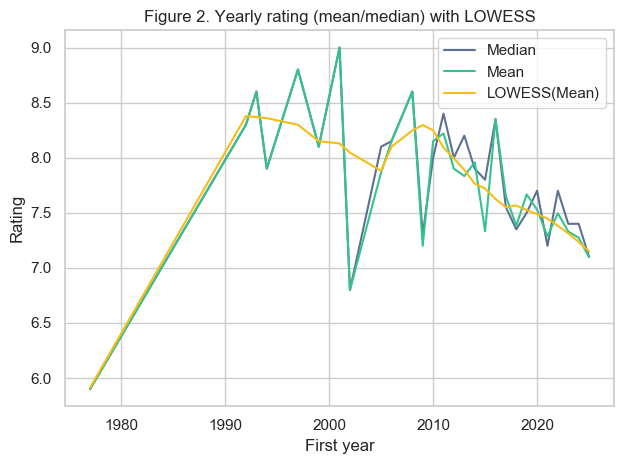

In [10]:
# 9) Figure 2: Yearly rating (mean/median) with LOWESS
plt.figure()
sns.lineplot(data=yearly_stats, x="year_first", y="rating_median", label="Median", color="#5D7092")
sns.lineplot(data=yearly_stats, x="year_first", y="rating_mean", label="Mean", color="#34C38F")
lw = lowess(yearly_stats["rating_mean"], yearly_stats["year_first"], frac=0.25, return_sorted=True)
plt.plot(lw[:,0], lw[:,1], color="#F6BD16", label="LOWESS(Mean)")
plt.title("Figure 2. Yearly rating (mean/median) with LOWESS")
plt.xlabel("First year"); plt.ylabel("Rating")
plt.legend(); plt.tight_layout(); plt.show()

Data analysis：
- Mean and median both climb through the 1980s–1990s, reaching a high around the 1990s (≈8.2–8.4).
- From the late 1990s to around 2000, the mean exhibits sharp peaks and troughs (peaking near 9 and dipping to ≈6.8), while the median remains smoother.
- After 2010, both curves drift downward toward ≈7.2–7.5, and the gap between mean and median narrows.
- The LOWESS smoother traces a nonlinear “rise—plateau—decline” pattern.

Interpretation：
- Ratings evolve nonlinearly—rising first and then declining. Early extreme swings are largely driven by sparse-year, single-point effects.
- In recent years, mean and median align more closely, indicating greater stability with larger samples, though the overall level is below the 1990s peak.

The time diagnostics surface three key facts: early years are extremely sparse, coverage is heavily skewed toward recent years, and ratings follow a nonlinear rise–plateau–decline pattern. Together, these suggest that rating distributions likely differ across eras and that the magnitude and direction of those differences are not uniform. To move from hints to evidence, we will next address three questions in a more systematic, statistics‑plus‑visuals framework: Do decades differ overall? How do those differences appear in visualization? Which decade pairs differ most? Where appropriate, we will report effect sizes and apply multiple‑testing corrections so that conclusions about decade differences are both intuitive and statistically sound.

## Statistical testing and localization of decade differences
Building on the earlier time diagnostics (early sparsity, right‑skewed coverage, and a rise–plateau–decline pattern), this section formally tests whether rating distributions differ by decade and, where differences exist, localizes which decade pairs drive them. The workflow forms a closed loop within the decade dimension: an omnibus test, a corroborating visualization, pairwise posthoc localization with multiple‑testing control, and a summary heatmap.

### Assess whether decades differ overall (Kruskal–Wallis)
To determine whether decade-level rating distributions are identical in aggregate and justify adding decade controls, we first test for an overall difference across decades; specifically, we run a Kruskal–Wallis omnibus test on ratings grouped by decade and report the effect size (epsilon²).

In [11]:
# 10) Kruskal–Wallis across decades
df_k = df_an.dropna(subset=["decade","Rating_w"]).copy()
groups = [g["Rating_w"].values for _, g in df_k.groupby("decade")]
if len(groups) > 1:
    kw_H, kw_p = stats.kruskal(*groups)
    N = sum(len(g) for g in groups); k = len(groups)
    eps2 = (kw_H - k + 1) / (N - k)
else:
    kw_H, kw_p, eps2 = np.nan, np.nan, np.nan
print(f"Kruskal–Wallis: H={kw_H:.2f}, p={kw_p:.3g}; epsilon^2={eps2:.3f}")

Kruskal–Wallis: H=36.92, p=1.87e-07; epsilon^2=0.172


Data analysis：
- Kruskal–Wallis across decades: H=36.92, p=1.87e−07, epsilon²=0.172.
Group sizes used in the test are highly unbalanced: 1970s n=1, 1990s n=7, 2000s n=18, 2010s n=50, 2020s n=120.

Interpretation：
- There is strong evidence that rating distributions are not identical across decades; the effect size is moderate (ε²≈0.17), indicating a meaningful decade component.
Because early decades are sparse (e.g., 1970s n=1), follow‑up contrasts should emphasize decades with adequate n to avoid over‑weighting anecdotal years.

### Visually summarize decade distributions and sample sizes
Because statistical significance benefits from an intuitive counterpart and coverage can vary by decade, we present box plots of ratings by decade to show level and dispersion while annotating the title with the Kruskal–Wallis p-value and each decade’s sample size (n) for transparent context.

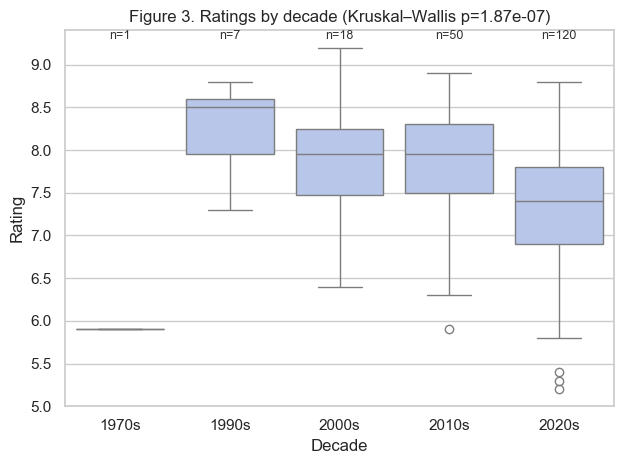

In [12]:
# 11) Figure 3: Ratings by decade
order = sorted(df_k["decade"].unique())
plt.figure()
ax = sns.boxplot(data=df_k, x="decade", y="Rating_w", order=order, color="#B0C2F2")
counts = df_k.groupby("decade")["Title"].count().to_dict()
for i, d in enumerate(order):
    n = counts.get(d, 0)
    ax.text(i, ax.get_ylim()[1], f"n={n}", ha="center", va="top", fontsize=9, color="#333")
title_kw = f"Figure 3. Ratings by decade (Kruskal–Wallis p={kw_p:.3g})" if np.isfinite(kw_p) else "Figure 3. Ratings by decade"
plt.title(title_kw)
plt.xlabel("Decade"); plt.ylabel("Rating")
plt.tight_layout(); plt.show()

Data analysis：
- 1990s shows the highest central tendency among well‑sampled decades with a tight spread.
- 2000s and 2010s are slightly lower than the 1990s and exhibit broader dispersion and higher upper whiskers.
- 2020s has the lowest median with a wide IQR and several low outliers, indicating increased variability and more low‑rated titles.
- 1970s consists of a single observation and yields an unstable box.

Interpretation：
- The visual pattern aligns with the omnibus result: decades differ both in level and dispersion. The recent decade skews lower and more variable, while the 1990s stands out as a relative high. Extremely small groups (e.g., 1970s) should not be over‑interpreted.


### Localize pairwise decade differences (Dunn posthoc with BH correction)
Given a significant omnibus result, we perform Dunn’s pairwise comparisons across decades and control the false discovery rate using Benjamini–Hochberg. We report adjusted p-values in a symmetric matrix and highlight pairs with substantive contrasts. These localized results identify specific “high vs. low” eras and guard against over‑interpreting small‑n decades.

In [13]:
# 12) Dunn posthoc (BH)
try:
    import scikit_posthocs as sp
    dunn_df = sp.posthoc_dunn(df_k, val_col="Rating_w", group_col="decade", p_adjust="fdr_bh")
except Exception as e:
    from statsmodels.stats.multitest import multipletests
    cats = list(df_k["decade"].dropna().unique())
    data_map = {c: df_k.loc[df_k["decade"]==c, "Rating_w"].dropna().values for c in cats}
    pairs = []
    for a, b in combinations(cats, 2):
        if len(data_map[a])>1 and len(data_map[b])>1:
            U, p = stats.mannwhitneyu(data_map[a], data_map[b], alternative="two-sided")
        else:
            U, p = np.nan, np.nan
        pairs.append((a,b,p))
    res = pd.DataFrame(pairs, columns=["g1","g2","p_raw"]).dropna()
    rej, p_adj, _, _ = multipletests(res["p_raw"].values, method="fdr_bh")
    cats_sorted = sorted(cats)
    dunn_df = pd.DataFrame(1.0, index=cats_sorted, columns=cats_sorted, dtype=float)
    for (g1,g2,pv), adj in zip(res.values, p_adj):
        dunn_df.loc[g1,g2] = adj
        dunn_df.loc[g2,g1] = adj
    np.fill_diagonal(dunn_df.values, np.nan)
display(dunn_df)

,1970s,1990s,2000s,2010s,2020s
1970s,1.000000,0.033177,0.062609,0.062609,0.232699
1990s,0.033177,1.000000,0.279379,0.232699,0.003438
2000s,0.062609,0.279379,1.000000,0.918400,0.004569
2010s,0.062609,0.232699,0.918400,1.000000,0.000035
2020s,0.232699,0.003438,0.004569,0.000035,1.000000


Data analysis:
- The 2020s differ significantly from all well-sampled earlier decades: vs 1990s (p≈0.0034), 2000s (p≈0.0046), and 2010s (p≈0.00004).
- 1990s vs 2000s and 1990s vs 2010s are not significant after BH correction (p≈0.274 and p≈0.233), indicating broadly similar central tendencies.
- 2000s vs 2010s is also non‑significant (p≈0.918), suggesting similar mid‑era distributions.
- The 1970s consists of a single observation; related p-values are unstable and should be treated as uninformative.

Interpretation:
- Posthoc localization identifies the 2020s as the main driver of the omnibus difference, sitting lower than the 1990s–2010s cluster.
- The 1990s–2010s form a statistically indistinguishable “platform,” consistent with the box‑plot overlap.
- Any inference involving the 1970s is unreliable due to extreme small‑n.

### Summarize the contrast landscape
To convey the overall pattern at a glance, we render a heatmap of BH‑adjusted p-values across all decade pairs and overlay significance stars. This figure completes the decade loop, consolidates where differences concentrate, supports narratives about potential “golden periods,” and motivates including decade fixed effects in subsequent regression.

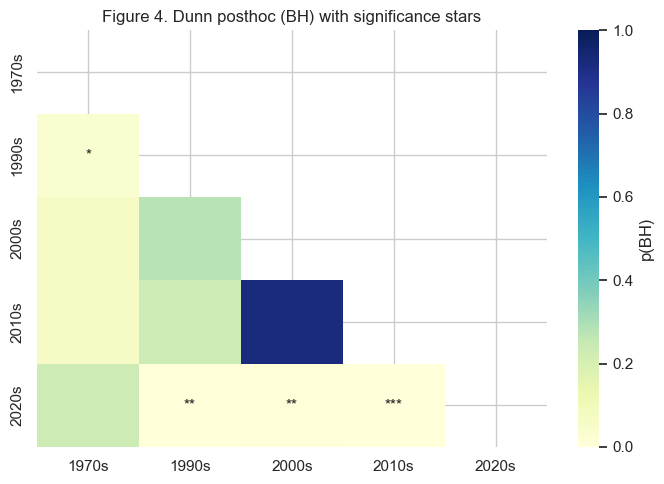

In [14]:
# 13) Figure 4: Dunn posthoc heatmap
def p_to_stars(p):
    return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""

mask = np.triu(np.ones_like(dunn_df, dtype=bool))
plt.figure(figsize=(7,5))
ax = sns.heatmap(dunn_df, mask=mask, vmin=0, vmax=1, cmap="YlGnBu", annot=False, cbar_kws={"label":"p(BH)"})
for i in range(dunn_df.shape[0]):
    for j in range(i):
        p = dunn_df.iloc[i,j]
        if pd.notna(p):
            ax.text(j+0.5, i+0.5, p_to_stars(p), ha="center", va="center", color="#222", fontsize=11)
plt.title("Figure 4. Dunn posthoc (BH) with significance stars")
plt.tight_layout(); plt.show()

Data analysis:
- Lighter cells and more stars denote stronger significance; the 2020s vs 1990s/2000s/2010s cells are light and marked with “/*,” highlighting robust differences.
- Cells among 1990s, 2000s, and 2010s are darker and star‑free, supporting non‑significance.
- Cells involving the 1970s reflect small‑n instability and should be ignored.

Interpretation:
- The heatmap corroborates the matrix: significance concentrates in “2020s vs mature decades,” while 1990s–2010s form a stable cluster.

The decade analysis can be summarized in three points: First, the Kruskal–Wallis omnibus test rejects identical decade distributions with a practically meaningful effect size, indicating that decade is a non‑negligible determinant of rating distributions. Second, the box plots show higher medians and tighter spreads in the 1990s–2010s, while the 2020s has a lower median, wider IQR, and more low outliers, implying recent ratings are lower and more variable whereas mid‑era decades are more stable. Third, BH‑corrected Dunn posthoc tests concentrate significance on contrasts between the 2020s and the other mature decades, with the 1990s–2010s largely indistinguishable, meaning the global difference is primarily driven by the 2020s rather than subtle gaps among mid‑era decades. Building on this, we proceed with a concise stats‑plus‑visuals workflow to examine other key dimensions: whether lifecycle status differs, how the two groups look visually, potential nonlinearity or interaction with duration, and platform time trends that may introduce confounding.

## Explore other key dimensions and identify potential confounding
Building on the decade findings, this section examines non‑temporal factors that may independently relate to ratings and potentially confound decade contrasts. We pair concise statistical tests with corroborating visuals and note interpretation caveats that inform subsequent regression design.

### Assess whether lifecycle status is associated with rating differences (Mann–Whitney U)
To test if titles that have Ended differ from those still Running before controlling confounders, we run a two‑sided Mann–Whitney U on ratings, reporting an effect size (e.g., Cliff’s delta) and the group medians. This yields a raw estimate of the status gap and flags whether Ended tends to outrank Running, while reminding us to control for other factors in regression.

In [15]:
# 14) Mann–Whitney Ended vs Running
sub = df_an[df_an["Status_bin"].isin(["Ended","Running"])].copy()
x = sub.loc[sub["Status_bin"]=="Ended","Rating_w"].dropna().values
y = sub.loc[sub["Status_bin"]=="Running","Rating_w"].dropna().values
if len(x)>0 and len(y)>0:
    mw_U, mw_p = stats.mannwhitneyu(x, y, alternative="two-sided")
else:
    mw_U, mw_p = np.nan, np.nan

def cliffs_delta(xv, yv):
    xv = np.asarray(xv); yv = np.asarray(yv)
    n1, n2 = len(xv), len(yv)
    if n1*n2 == 0: return np.nan
    gt = sum((xi > yv).sum() for xi in xv)
    lt = sum((xi < yv).sum() for xi in xv)
    return (gt - lt) / (n1*n2)

delta = cliffs_delta(x, y)
print(f"Mann–Whitney: U={mw_U:.1f}, p={mw_p:.4f}; Cliff's δ={delta:.3f}; medians {np.median(x):.2f} vs {np.median(y):.2f}")

Mann–Whitney: U=3623.0, p=0.0037; Cliff's δ=0.297; medians 7.90 vs 7.50


Data analysis：
- Mann–Whitney U comparing Ended vs Running: U=3623.0, p=0.0037.
- Cliff’s delta=0.297; medians: Ended 7.90 vs Running 7.50.

Interpretation：
- Ended titles tend to score higher than Running titles with a small‑to‑moderate effect. Roughly, an Ended title has about a 65% chance to outrank a Running title in a random draw.
- This factor is orthogonal to decade and should be controlled for or stratified in decade comparisons.

### Visually summarize the two lifecycle groups
To provide an intuitive counterpart to the U‑test and make the distributional shift interpretable, we plot Ended vs Running (including TBD where relevant) with box or violin plots. The title annotates the p‑value and Cliff’s delta, giving at‑a‑glance evidence about central tendency and spread that we will later verify under controls.

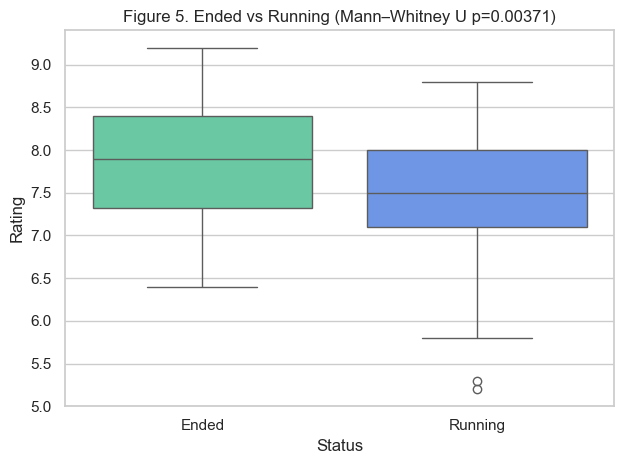

In [16]:
# 15) Figure 5: Ended vs Running
plt.figure()
sns.boxplot(
    data=sub,
    x="Status_bin",
    y="Rating_w",
    order=["Ended", "Running"],
    hue="Status_bin",
    palette={"Ended": "#5AD8A6", "Running": "#5B8FF9"},
    dodge=False,
    legend=False           
)
ttl = f"Figure 5. Ended vs Running (Mann–Whitney U p={mw_p:.3g})" if np.isfinite(mw_p) else "Figure 4. Ended vs Running"
plt.title(ttl)
plt.xlabel("Status"); plt.ylabel("Rating")
plt.tight_layout(); plt.show()

Data analysis：
- Box plot shows a higher median and upper range for Ended; Running displays wider spread toward lower ratings and low‑end outliers.

Interpretation：
- The visualization confirms the U‑test: the distribution shift favors Ended titles. When attributing decade differences, consider potential composition effects from the mix of Ended vs Running titles in each decade.

### Probe nonlinearity and status interaction with duration (scatter + grouped LOWESS)
Because rating–duration relationships may be nonlinear and differ by lifecycle status, we draw a scatter of rating vs duration with overall and status‑specific LOWESS curves. Divergent shapes or weak linear trends would caution against simple OLS main effects and guide model specification (e.g., splines or interactions).

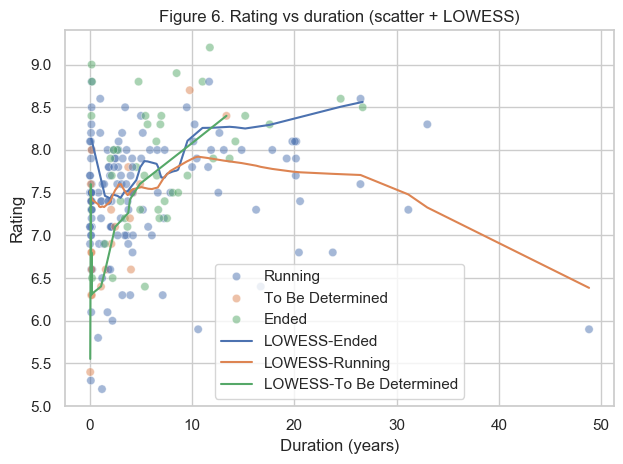

In [17]:
# 16) Figure 6: Rating vs duration (scatter + LOWESS)
plt.figure()
sns.scatterplot(data=df_an, x="duration_years", y="Rating_w", hue="Status_bin", alpha=0.5)
for k, subk in df_an.groupby("Status_bin"):
    if len(subk) > 15:
        lw2 = lowess(subk["Rating_w"], subk["duration_years"], frac=0.3, return_sorted=True)
        plt.plot(lw2[:,0], lw2[:,1], label=f"LOWESS-{k}")
plt.title("Figure 6. Rating vs duration (scatter + LOWESS)")
plt.xlabel("Duration (years)"); plt.ylabel("Rating")
plt.legend(); plt.tight_layout(); plt.show()

Data analysis :
- In the short-duration range (about 0–5 years), all three status groups rise quickly, indicating ratings improve as titles accumulate time early in their run.
- The Ended group’s LOWESS keeps climbing from roughly 5–25 years and then plateaus at a high level with a slight pullback in the tail; overall it is highest and relatively smooth.
- The Running group shows a clear downward slope after about 10 years and continues to decline beyond 20 years, suggesting long-running titles are more prone to rating fatigue.
- The TBD group is concentrated in short to mid durations; its curve is close to or slightly below the Ended median level, with larger variance.
- Ratings at the same duration span a wide range, implying factors beyond duration also affect ratings.
  
Interpretation:
- There is pronounced nonlinearity and status-specific shape differences: early rise, a high plateau for Ended, and long-term decline for Running.
- Conclusions for TBD are limited by sample size and coverage and should be treated with caution.

### Check platform‑specific temporal trends and coupling with decade (Top‑6 small multiples)
Platforms may have distinct rating trajectories and uneven activity across decades, creating platform–decade coupling. We facet yearly mean ratings by the top six platforms and overlay LOWESS. If a platform’s active years cluster within specific decades, subsequent regressions should include both platform and decade terms to mitigate confounding.

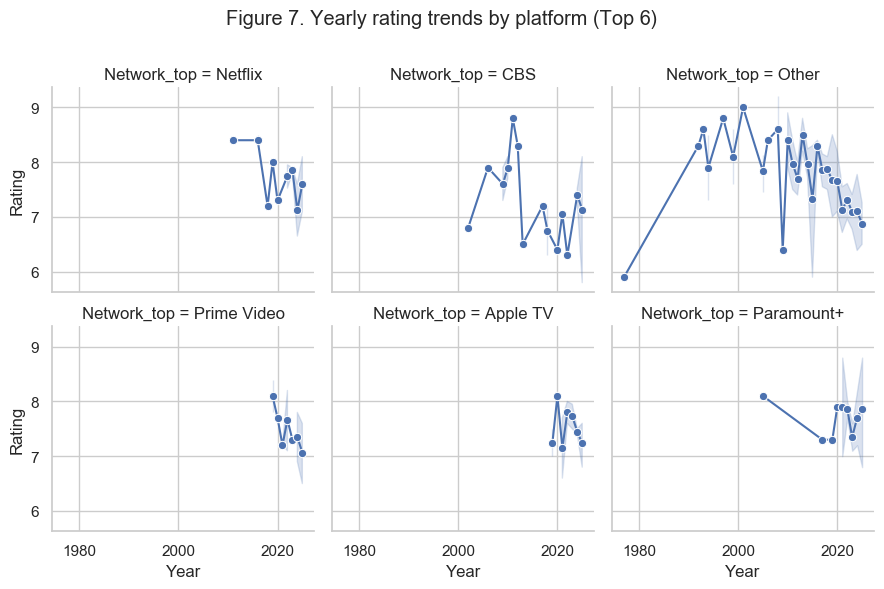

In [18]:
# 17) Figure 7: Yearly rating trends by platform (Top 6)
top6 = df_an["Network_top"].value_counts().head(6).index.tolist()
df_top = df_an[df_an["Network_top"].isin(top6)].copy()
g = sns.FacetGrid(df_top, col="Network_top", col_wrap=3, height=3, sharey=True)
g.map_dataframe(sns.lineplot, x="year_first", y="Rating_w", marker="o")
g.set_axis_labels("Year","Rating")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Figure 7. Yearly rating trends by platform (Top 6)")
plt.show()

Data analysis:
- Netflix: concentrated in recent years; means fall from a high level to mid-high, with increased volatility lately.
- CBS: covers earlier decades; a peak appears in the mid-to-late 2000s, then declines and stays at a medium-to-low level in recent years.
- Other (miscellaneous platforms): steady climb from early years to a peak around 2010, then gradual retreat, with larger variance recently.
- Prime Video: observed only in recent years; hovers near the median with a slight downward drift and noticeable fluctuation.
- Apple TV: limited to very recent years; average level is moderately high but quite volatile, with a mild downward trend.
- Paramount+: very new samples; mid-level ratings with large year-to-year swings and instability.

Interpretation:
- Platforms’ active periods are unevenly distributed across decades, indicating platform–decade coupling.
- Time trends differ across platforms: some rise then fall, others keep declining; newer platforms exhibit greater volatility due to sparse samples.

Overall, the visuals and statistics together point to three core conclusions: First, the two-sided Mann–Whitney U test rejects “identical distributions for Ended and Running,” with a small-to-moderate Cliff’s delta; combined with the median gap, this indicates a practically meaningful association between lifecycle status and ratings. Second, the box plot shows the Ended group with a higher median, longer upper whisker, and a narrower IQR, while the Running group exhibits a wider spread and more low-end outliers—suggesting in-progress titles are more prone to lower scores and greater volatility. Third, the rating–duration relationship follows a nonlinear “early rise—mid plateau—late decline” pattern, and the shapes differ by status: Ended holds a high plateau for roughly 5–25 years, Running trends downward after about 10 years, and TBD concentrates in short-to-mid durations with larger variance. Meanwhile, the platform small multiples reveal asynchronous year-to-year trajectories and recent-year clustering, implying platform–decade coupling; sparse early years and newer platforms add instability.

Building on this, we will proceed with a concise statistics-plus-visuals workflow: construct the design matrix with basic robustness steps, run robust regression for inference, and use compact plots to report key coefficients and their uncertainty.

## Regression modeling and robust inference
Building on the decade findings, this section completes a compact statistics-plus-visuals loop from modeling to presentation: first estimating marginal effects under key controls for confounding, then visualizing the uncertainty around core coefficients to keep conclusions both clear and reliable.

### Model construction and robust estimatio
To obtain credible marginal effects after controlling for confounders, we first construct the design matrix and perform basic robustness steps, then run robust regression, and briefly check multicollinearity via the condition number.

In [19]:
# 18) OLS (HC3) with controlled dimensions — simplified and robust

X_parts = []

dec_dum = pd.get_dummies(df_an["decade"].astype("category"), prefix="decade", drop_first=True).astype(float)
X_parts.append(dec_dum)

X_cont = pd.DataFrame({
    "duration_years": pd.to_numeric(df_an["duration_years"], errors="coerce").fillna(0).astype(float)
}, index=df_an.index)
X_parts.append(X_cont)

status_dum = pd.get_dummies(df_an["Status_bin"].astype("category"), prefix="Status_bin", drop_first=True).astype(float)
X_parts.append(status_dum)

net_dum = pd.get_dummies(df_an["Network_top"].astype("category"), prefix="Network_top", drop_first=True).astype(float)
X_parts.append(net_dum)

G = pd.DataFrame(index=df_an.index)
for c in genre_cols:
    G[c] = pd.to_numeric(df_an[c], errors="coerce").fillna(0).astype(int).astype(float)
X_parts.append(G)

X = pd.concat(X_parts, axis=1)
nunq = X.nunique(dropna=True)
const_like = nunq[nunq <= 1].index.tolist()
if const_like:
    X = X.drop(columns=const_like)

X = X.apply(pd.to_numeric, errors="coerce").astype(float)
y = pd.to_numeric(df_an["Rating_w"], errors="coerce").astype(float)
Xc = sm.add_constant(X, has_constant="add")

mask = np.isfinite(y) & np.all(np.isfinite(Xc.values), axis=1)

res = sm.OLS(y[mask], Xc.loc[mask]).fit(cov_type="HC3")
print(res.summary())

try:
    cond_number = np.linalg.cond(Xc.loc[mask].values)
    print(f"Condition number (decade FE): {cond_number:.2e}")
except Exception:
    pass

                            OLS Regression Results                            
Dep. Variable:               Rating_w   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     3.262
Date:                Tue, 28 Oct 2025   Prob (F-statistic):           1.35e-05
Time:                        22:58:07   Log-Likelihood:                -177.78
No. Observations:                 196   AIC:                             397.6
Df Residuals:                     175   BIC:                             466.4
Df Model:                          20                                         
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

Data analysis:
- Decade (relative to the dropped reference decade):
1. 1990s: coef ≈ +2.02, p ≈ 0.028, indicating a significantly higher rating level than the reference decade.
2. 2000s, 2010s, 2020s: positive coefficients but p > 0.05 (2010s and 2020s even less significant); directionally higher but statistically weak.
- Lifecycle status (reference = Ended):
1. Running: coef ≈ −0.18, p ≈ 0.138; negative direction, close but not significant.
2. TBD: coef ≈ −0.52, p ≈ 0.012; significantly lower than Ended with a larger magnitude.
- Platform (reference = Other or the dropped category):
1. CBS: coef ≈ −0.523, p ≈ 0.024; significantly lower than the reference platform.
2. Other platforms (Netflix, Paramount+, Prime Video): not significant; small directional differences.
- Duration and genre:
1. duration_years: coef ≈ −0.008, p ≈ 0.830; not significant, weak linear main effect.
2. Most genres are not significant; Drama is slightly positive and marginally significant (p ≈ 0.043); Adventure is near‑marginal (p ≈ 0.083).
- Model and diagnostics:
1. R^2 ≈ 0.318 (Adj. ≈ 0.240), offering some explanatory power with controls.
2. HC3 robust standard errors used; condition number ≈ 4.07e+02, indicating some collinearity but within an acceptable range.

Interpretation:
- After controlling for decade, platform, genre, and duration, a “status effect” remains: Running vs. Ended is negative but not significant; TBD is significantly negative, indicating that “to be determined” titles score lower even after controls.
- The 1990s retain a positive advantage in regression, suggesting its higher ratings are not purely compositional.
- CBS’s negative and significant effect suggests distribution channel/audience ecosystems can matter for ratings.
- The non‑significant linear duration term echoes earlier nonlinearity: a single linear term fails to capture the rise–plateau–decline shape.

### Visualization of adjusted status effects
To present the controlled results intuitively, we extract the status-related coefficients and their intervals, and use an error-bar chart to show effect direction, magnitude, and uncertainty.

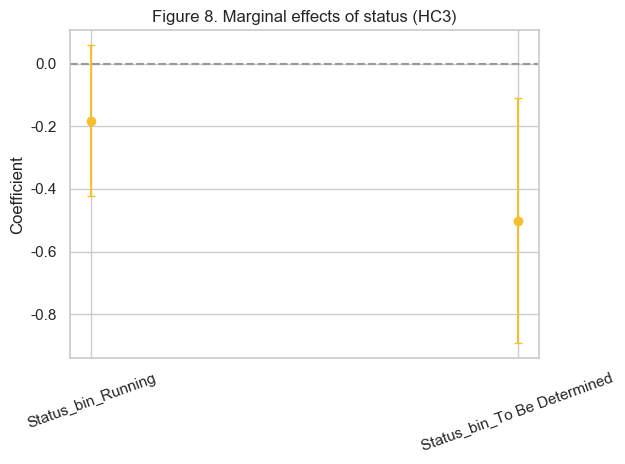

In [20]:
# 19) Figure 8: Marginal effects of status (HC3)
status_cols = [c for c in Xc.columns if c.startswith("Status_bin_")]
if status_cols:
    plt.figure()
    xs = np.arange(len(status_cols))
    coefs = [res.params[c] for c in status_cols]
    ses = [res.bse[c] for c in status_cols]
    plt.errorbar(xs, coefs, yerr=1.96*np.array(ses), fmt="o", color="#F6C02D", capsize=3)
    plt.axhline(0, color="#999", ls="--")
    plt.xticks(xs, status_cols, rotation=20)
    plt.title("Figure 8. Marginal effects of status (HC3)")
    plt.ylabel("Coefficient")
    plt.tight_layout(); plt.show()
else:
    print("No Status_bin_* dummies after encoding.")

Data analysis:
- Running: point estimate ≈ −0.18, 95% CI crosses 0; negative direction but not significant, small‑to‑moderate magnitude.
- TBD: point estimate ≈ −0.52, 95% CI clearly below 0; significantly negative, moderate‑to‑larger magnitude.
- Different bar heights show differing uncertainty: strong evidence for TBD, weaker for Running.

Interpretation:
- The visualization aligns with the regression table: relative to Ended, Running’s negative effect is unstable, while TBD’s negative effect is robust and significant.
- The figure closes the loop from raw group gaps to adjusted marginal effects: status differences are not fully driven by platform, genre, or decade composition, and the adverse TBD effect persists with practical relevance.

Synthesizing the regression table and the error‑bar plot, the takeaway is clear: after jointly controlling for decade, platform, genre, and duration, status still has an independent effect—Running is slightly lower than Ended but not significant, while TBD is clearly and robustly lower, indicating a substantive link between “to be determined” status and lower ratings. Decade and platform also matter— the 1990s are significantly higher and CBS is significantly lower—yet these differences do not explain away the status effect. The linear duration term is not significant, aligning with the previously observed nonlinear “early rise—mid plateau—late decline” pattern. Overall model fit is moderate (R^2 ≈ 0.32) with manageable collinearity, and the error bars further show weak evidence for Running versus strong evidence for TBD.

## Conclusion

In [21]:
# 20) Summary
print("\nSummary")
print(f"- Decade differences: H={kw_H:.2f}, p={kw_p:.2e}, epsilon^2={eps2:.3f}")
print(f"- Ended vs Running: U={mw_U:.1f}, p={mw_p:.4f}, Cliff's δ={delta:.3f}, medians {np.median(x):.2f} vs {np.median(y):.2f}")
print("- OLS uses HC3; platforms limited to Top 8 (+Other); genres filtered by frequency (>=10).")


Summary
- Decade differences: H=36.92, p=1.87e-07, epsilon^2=0.172
- Ended vs Running: U=3623.0, p=0.0037, Cliff's δ=0.297, medians 7.90 vs 7.50
- OLS uses HC3; platforms limited to Top 8 (+Other); genres filtered by frequency (>=10).


Overall findings:
Ratings are jointly influenced by Era (decade) and Status (Running/Ended/TBD), with consistent evidence along both lines. 
Decade distributions differ significantly (Kruskal–Wallis H=36.92, p=1.87e−07, ε^2≈0.17, a medium effect).Lifecycle status is substantively associated with ratings—Ended is clearly higher than Running (U=3623.0, p=0.0037, Cliff’s δ≈0.30; medians 7.90 vs 7.50).In the regression using HC3 robust standard errors, limiting platforms to Top 8 + Other and filtering genres by frequency, the status effect persists even after controlling for decade, platform, genre, and duration: Running is slightly but not robustly lower than Ended, and TBD is robustly and more strongly ower. The linear duration term is not significant, aligning with the earlier nonlinear shape. In short, era and platform shift the overall level, but lifecycle status—especially TBD—exerts an independent downward influence that merits attention.

Direct answers to the three research questions:
  - Q1 (premiere year and “golden windows”): Partly yes, but contrary to the original hypothesis. Decade differences are significant (H=36.92, p=1.87e−07), and the regression advantage leans toward the 1990s rather than 2010. Current evidence points to the 1990s; we cannot confirm 2010 as the golden window.
  - Q2 (Ended vs Running and concentration of top ratings): Opposite to the hypothesis. Ended generally rates higher than Running (median 7.90 vs 7.50; U=3623.0, p=0.0037, δ≈0.30). After controlling for covariates, Running remains slightly lower but not significant, and TBD is significantly lower. Therefore, high ratings are not more concentrated among long‑running in‑progress shows.
  - Q3 (longevity and reception): The simple claim “longer is better” is not supported. The linear duration term is not significant, and the overall pattern follows a nonlinear “early rise—mid plateau—late decline,” consistent with survivor‑bias concerns; longevity alone does not guarantee higher ratings.